<a href="https://colab.research.google.com/github/Ryan-RE-Wang/MIMIC_Racial_Fairness_Project/blob/main/MIMIC_Racial_Fairness_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import tensorflow as tf
import cv2 as cv
import gc
from enum import Enum
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'
core:
  account: ryanwang@gapp.nthu.edu.tw

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you would like to use to perform operations for 
this configuration:
 [1] ryanwang@gapp.nthu.edu.tw
 [2] Log in with a new account
Please enter your numeric choice:  1

You are logged in as: [ryanwang@gapp.nthu.edu.tw].

Pick cloud project to use: 


In [ ]:
df_pa = pd.read_csv('/content/gdrive/MyDrive/patients.csv')
df_chexpert = pd.read_csv('/content/gdrive/Shared drives/MIMIC project/mimic-cxr-2.0.0-chexpert.csv')
df_ad = pd.read_csv('/content/gdrive/Shared drives/MIMIC project/admissions.csv')
df_meta = pd.read_csv('/content/gdrive/MyDrive/metadatas/metadata_fix.csv')

# Download Image from mimic_cxr




In [ ]:
df_missed = pd.read_csv('/content/gdrive/MyDrive/metadatas/mimic_cxr_missing.csv')
missed = df_missed['subject_id'].unique()

In [ ]:
!rm -rf downloads/
!rm -rf list_name.txt

In [ ]:
path = '/content/downloads/'

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

url = 'gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p'
f = open('list_name.txt',"w+")
for id in missed:
  source = '/content/gdrive/MyDrive/downloads/p'+(str(id))
  if (os.path.exists(source)):
    continue
  dir = url + str(id)[:2] + '/p' + str(id) + '/'
  f.write(dir)
  f.write('\n')
f.close()

Successfully created the directory /content/downloads/ 


In [ ]:
cat list_name.txt | gsutil -m cp -I -r ./downloads/

Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s50771383/2a280266-c8bae121-54d75383-cac046f4-ca37aa16.jpg...
Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s50771383/0c4eb1e1-b801903c-bcebe8a4-3da9cd3c-3b94a27c.jpg...
Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s54205396/8959e402-2175d68d-edba5a6c-baab51c3-9359f700.jpg...
Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s54205396/9e7a6aae-2580e589-6212d336-9813ebbd-a9239a34.jpg...
Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000898/s54205396/b75df1bd-0f22d631-52d73526-2ae7b85a-d843b39d.jpg...
\ [5/5 files][  8.4 MiB/  8.4 MiB] 100% Done                                    
Operation completed over 5 objects/8.4 MiB.                                      


In [ ]:
from PIL import Image
import os

path = '/content/downloads/'
dirs = os.listdir(path)

for i in range(len(dirs)):
  subject_dirs = os.listdir( path + dirs[i] )
  for j in range(len(subject_dirs)):
    subject_dirs_items = os.listdir( path + dirs[i] + '/' + subject_dirs[j])
    for item in range(len(subject_dirs_items)):
      file_path = path + dirs[i] + '/' + subject_dirs[j] + '/' + subject_dirs_items[item]
      if os.path.isfile(file_path):
          im = Image.open(file_path)
          imResize = im.resize((256,256), Image.ANTIALIAS)
          imResize.save(file_path, 'JPEG', quality=90)
  id = dirs[i]
  print(id)
  !cp -r '/content/downloads/$id' '/content/gdrive/MyDrive/downloads'

p10000898


#Data Preprocess

In [ ]:
import os 

path = '/content/gdrive/Shared drives/MIMIC project/downloads/'

dirs = os.listdir(path)

In [ ]:
from PIL import Image
from numpy import asarray

x_train = []
count = 0

for i in range(len(dirs)):
    subject_dirs = os.listdir( path + dirs[i] )
    for j in range(len(subject_dirs)):
      subject_dirs_items = os.listdir( path + dirs[i] + '/' + subject_dirs[j])
      for item in range(len(subject_dirs_items)):
        file_path = path + dirs[i] + '/' + subject_dirs[j] + '/' + subject_dirs_items[item]
        x_train.append(asarray(Image.open(file_path)))
        count += 1
        print(count)

In [ ]:
print(np.array(x_train).shape)

In [ ]:
from PIL import Image
from numpy import asarray

image = Image.open(image_path[0])

data = asarray(image)

print(data)

[[  0   3   6 ...   0   0   0]
 [ 11   0   0 ...   0   0   0]
 [  0   3   1 ...   0   0   0]
 ...
 [240 240 241 ... 169 167 165]
 [241 241 242 ... 170 168 167]
 [241 241 242 ... 172 170 169]]


# TFRecord


In [ ]:
ls 'gdrive/Shared drives/MIMIC project/downloads/'

In [ ]:
import os
path = 'gdrive/Shareddrives/MIMIC project/downloads/'
dirs = os.listdir(path)
src = []
dicomId = []
count = 0
for i in range(len(dirs)):
    subject_dirs = os.listdir( path + dirs[i] )
    for j in range(len(subject_dirs)):
      subject_dirs_items = os.listdir( path + dirs[i] + '/' + subject_dirs[j])
      count += len(subject_dirs_items)
      print(count)
    #   for item in range(len(subject_dirs_items)):
    #     file_path = path + dirs[i] + '/' + subject_dirs[j] + '/' + subject_dirs_items[item]
    #     src.append(file_path)
    #     dicomId.append(item)
    #     print(count)
    #     count += 1


In [ ]:
print(count)

In [ ]:
import os 
path = '/content/gdrive/Shared drives/MIMIC project/downloads'

dirs = os.listdir(path)

metadata_fix = pd.DataFrame()

count = 0

for i in range(len(dirs)):
  id = int(dirs[i].replace('p', ''))
  metadata_fix = metadata_fix.append(df_meta.loc[df_meta['subject_id'] == id])
  # metadata_fix = df_meta.loc[df_meta['subject_id'] == id]
  count += len(metadata_fix)
  print(i, id)

In [ ]:
metadata_fix.to_csv('metadata_fix.csv')

In [ ]:
!cp -r 'PA_meta9.csv' '/content/gdrive/My Drive'

In [ ]:
def get_ethnicity(race):
  return {
      'WHITE':0,
      'BLACK/AFRICAN AMERICAN':1,
      'HISPANIC/LATINO':2,
      'OTHER':3,
      'ASIAN':4,
      'UNKNOWN':5,
      'UNABLE TO OBTAIN':6,
      'AMERICAN INDIAN/ALASKA NATIVE':7
  }.get(race, 5)

In [ ]:
import io
import tensorflow as tf
import numpy as np
import csv
import os 
import shutil
import pathlib
from PIL import Image
from PIL import ImageOps
import cv2 as cv
import pathlib
import os.path
from os import path

# record_iterator = tf.io.tf_record_iterator(path="tfrecords_valid_frontal-00000-of-00003.tfrecord")
# for string_record in record_iterator:
#     break

id_count = 0

record_file = '/content/gdrive/My Drive/TFrecords/mimic-tf-record15.tfrecords'

with tf.io.TFRecordWriter(record_file) as writer:
  with open('/content/gdrive/My Drive/metadatas/meta15.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    next(spamreader)

    for row in spamreader:    

      # print(row)
      # df = metadata.loc[metadata['dicom_id'] == row[0]]
        # if (row[0]['ViewPosition'] == 'PA' or row[0]['ViewPosition'] == 'AP'):
      df_of_row = df_chexpert.loc[df_chexpert['subject_id'] == int(float(row[2]))]# chexpert['study_id'] == int(row[2])]
      df_of_row = df_of_row.loc[df_of_row['study_id'] == int(float(row[3]))]
      df_of_row.reset_index(drop=True, inplace=True)
      # head_tail = os.path.split(row[0]) 
      # view = head_tail[1].replace('view', '').replace('_frontal', '').replace('_lateral', '')
      # head_tail = os.path.split(head_tail[0])
      subject = str(int(float(row[2])))
      # head_tail = os.path.split(head_tail[0])
      study = str(int(float(row[3])))
      dicom = row[1]

      if (df_of_row.empty):
        print('qaq')
        continue
      
      example = tf.train.Example()
      # example.ParseFromString(string_record)
      # p = pathlib.PureWindowsPath(row[0])                
          
      source = '/content/gdrive/Shared drives/MIMIC project/downloads' + '/p' + subject + '/s' + study + '/' + dicom+ '.jpg'
      
      """
      with open(source, 'rb') as fd:
          imgByteArr=fd.read()
            #from Byte to Img
          imageStream = io.BytesIO(imgByteArr)
          imageOrigin = Image.open(imageStream)
          Replace your function here
          newsize = (320, 320) 
          img = imageOrigin.resize(newsize)            
            #from Img to Byte
          imgByteArr = io.BytesIO()
          img.save(imgByteArr, format='JPEG')
          imgByteArr = imgByteArr.getvalue() 
      """   
      # newsize = (320, 320)
      if (not path.exists(source)):
        continue
      img = Image.open(source)

      img = img.resize((256,256), Image.ANTIALIAS)

      img = ImageOps.equalize(img)
      imgByteArr = io.BytesIO()
      img.save(imgByteArr, format='JPEG')
      imgByteArr = imgByteArr.getvalue()

      race = df_data[df_data['subject_id'] == int(subject)]['ethnicity'].values

      ethnicity = get_ethnicity(str(race[0]))

      # ethnicity_count[ethnicity] += 1

      # success, encoded_image = cv.imencode('.jpg', img)
      # imgByteArr = encoded_image.tobytes()                                                   
      
      # 1.0 0.0 -1.0 nan
      # df_of_row = df_of_row.replace({1: int(3), 0: int(2), -1: int(1), np.nan: int(0)})
      # print(df_of_row)
          # Put it back to tf_record
      example.features.feature['jpg_bytes'].bytes_list.value.append(imgByteArr)  
      example.features.feature['Atelectasis'].float_list.value.append(df_of_row['Atelectasis'][0])
      example.features.feature['Cardiomegaly'].float_list.value.append(df_of_row['Cardiomegaly'][0])
      example.features.feature['Consolidation'].float_list.value.append(df_of_row['Consolidation'])
      example.features.feature['Edema'].float_list.value.append(df_of_row['Edema'][0])
      example.features.feature['Enlarged Cardiomediastinum'].float_list.value.append(df_of_row['Enlarged Cardiomediastinum'][0])
      example.features.feature['Fracture'].float_list.value.append(df_of_row['Fracture'][0])
      example.features.feature['Lung Lesion'].float_list.value.append(df_of_row['Lung Lesion'][0])
      example.features.feature['Lung Opacity'].float_list.value.append(df_of_row['Lung Opacity'][0])
      example.features.feature['No Finding'].float_list.value.append(df_of_row['No Finding'][0])
      example.features.feature['Pleural Effusion'].float_list.value.append(df_of_row['Pleural Effusion'][0])
      example.features.feature['Pleural Other'].float_list.value.append(df_of_row['Pleural Other'][0])
      example.features.feature['Pneumonia'].float_list.value.append(df_of_row['Pneumonia'][0])
      example.features.feature['Pneumothorax'].float_list.value.append(df_of_row['Pneumothorax'][0])
      example.features.feature['Support Devices'].float_list.value.append(df_of_row['Support Devices'][0])

      example.features.feature['subject_id'].int64_list.value.append(int(subject))
      example.features.feature['study_id'].int64_list.value.append(int(study))
      example.features.feature['ethnicity'].int64_list.value.append(ethnicity)
      # example.features.feature['dicom_id'].int64_list.value[0] = int(view[:-4])
      # print(example)
      writer.write(example.SerializeToString())

      print(id_count, img.size)
      id_count += 1
      if (img.size != (256,256)):
        break

# DenseNet121 use tfrecord


In [ ]:
from enum import Enum
import multiprocessing

class Labels(Enum):
  no_finding = 0
  enlarged_cardiomediastinum = 1
  cardiomegaly = 2
  lung_opacity = 3
  lung_lesion = 4
  edema = 5
  consolidation = 6
  pneumonia = 7
  Atelectasis = 8
  pneumothorax = 9
  pleural_effusion = 10
  pleural_other = 11
  fracture = 12
  support_devices = 13

In [ ]:
filename = '/content/gdrive/My Drive/TFrecords/mimic-tf-record7.tfrecords'
raw_dataset = tf.data.TFRecordDataset(filename)

In [ ]:
#@title Input pipeline parameters {run: "auto"}
BATCH_SIZE =   32#@param {type: "integer"}
NUM_EPOCHS =   5#@param {type: "integer"}
U_VALUE = 0  #@param {type:"slider", min:0, max:1, step:0.01}
W_VALUE = 1  #@param {type:"slider", min:0, max:1, step:0.01}

In [ ]:
# label -> probability table: 0 -> 0, 1 -> 0, 2 -> u, 3 -> 1
probabs_lookup = tf.constant([0.0, 0.0,  1.0, U_VALUE])
# label -> weight table: 0 -> 1, 1 -> 1, 2 -> w, 3 -> 1
weights_lookup = tf.constant([1.0, 1.0,  1.0, W_VALUE])

In [ ]:
nan_val = tf.Variable([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])
min_val = tf.Variable([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

labels = tf.math.subtract(nan_val, min_val)

labels = tf.cast(labels, np.int32)

In [ ]:
feature_description = {'jpg_bytes': tf.io.FixedLenFeature([], tf.string)}
for l in Labels:
  feature_description[l.name] = tf.io.FixedLenFeature([], tf.int64)

# The height, width, and number of channels of the input images
INPUT_HWC = (256, 256, 3)

def parse_function(example):
  """Convert a TFExample from a TFRecord into an input and its true label.

    Args:
      example (tf.train.Example): A training example read from a TFRecord.

    Returns:
      Tuple[tf.Tensor, tf.Tensor]: The X-ray image and its labels. The labels
        are represented as two stacked arrays. One array is the probability
        that this label exists in the image, the other is how much weight this
        label should have when training the model.
    """
  parsed = tf.io.parse_single_example(example, feature_description)
  # Turn the JPEG data into a matrix of pixel intensities
  image = tf.io.decode_jpeg(parsed['jpg_bytes'], channels=1)
  # Give the image a definite size, which is needed by TPUs
  image = tf.reshape(image, INPUT_HWC)
  # Normalize the pixel values to be between 0 and 1
  scaled_image = (1.0 / 255.0) * tf.cast(image, tf.float32)
  # Combine the labels into an array
  labels = tf.stack([parsed[l.name] for l in Labels], axis=0)

  nan_val = tf.Variable([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])
  min_val = tf.Variable([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

  labels = tf.cast(labels, np.float32)

  tf.where(tf.math.is_nan(labels), nan_val, labels)

  labels = tf.math.subtract(labels, min_val)

  labels = tf.cast(labels, np.int32)
  # Convert the labels into probabilities and weights using lookup tables.
  probs = tf.gather(probabs_lookup, labels)
  weights = tf.gather(weights_lookup, labels)

  # Return the input to the model and the true labels
  return scaled_image, tf.stack([probs, weights], axis=0)


def get_dataset(tf_records):
  """Construct a pipeline for loading the data.

    Args:
      valid (bool): If this is True, use the validation dataset instead of the
        training dataset.

    Returns:
      tf.data.Dataset: A dataset loading pipeline ready for training.
    """
  n_cpu = multiprocessing.cpu_count()
  dataset = tf.data.TFRecordDataset(
      tf.io.gfile.glob(tf_records),
      buffer_size=16 * 1024 * 1024,
      num_parallel_reads=n_cpu)
  dataset = dataset.shuffle(256)
  dataset = dataset.repeat()
  dataset = dataset.map(parse_function, num_parallel_calls=n_cpu)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset



In [ ]:
INPUT_HWC = (256, 256, 3)
base_model = tf.keras.applications.densenet.DenseNet121(
      include_top=False, weights=None, input_shape=INPUT_HWC, pooling='max')
  
predictions = tf.keras.layers.Dense(
    14, activation='linear')(
        base_model.output)
 
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
def weighted_binary_crossentropy(prob_weight_y_true, y_pred):
    """Binary cross-entropy loss function with per-sample weights."""
    prob_weight_y_true = tf.reshape(prob_weight_y_true, (-1, 2, len(Labels)))
    # Unpack the second output of our data pipeline into true probabilities and
    # weights for each label.
    probs = prob_weight_y_true[:, 0]
    weights = prob_weight_y_true[:, 1]
    return tf.compat.v1.losses.sigmoid_cross_entropy(
        probs,
        y_pred,
        weights,
        reduction=tf.compat.v1.losses.Reduction.SUM_OVER_BATCH_SIZE)

In [ ]:
from tensorflow.keras import optimizers 
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model.compile(optimizer='adam',
              loss=weighted_binary_crossentropy
              )
 
# model.fit(
#     X_train, y_train,
#     epochs=NUM_EPOCHS,
#     steps_per_epoch=len(X_train) // BATCH_SIZE,
#     validation_data=(X_test, y_test),
#     validation_steps=len(X_test) // BATCH_SIZE)#,

In [ ]:
history = model.fit(get_dataset(filename), batch_size=32 , epochs=5, steps_per_epoch=10000 // BATCH_SIZE)

Epoch 1/5


FailedPreconditionError: ignored

# Statistic

In [ ]:
path = '/content/gdrive/MyDrive/Racial_project_result/ethnicity_age_ratio.csv'
result_ = pd.read_csv(path, index_col=0)
result_

,-20,20-40,40-60,60-80,80-
index,,,,,
WHITE,0.512146,0.505297,0.606634,0.695301,0.755919
BLACK/AFRICAN AMERICAN,0.154858,0.217172,0.192003,0.143221,0.095538
HISPANIC/LATINO,0.084008,0.109017,0.072142,0.039671,0.022284
OTHER,0.053644,0.060688,0.051991,0.043656,0.035890
ASIAN,0.073887,0.035887,0.028754,0.033016,0.033882
UNKNOWN,0.109312,0.064753,0.039958,0.038325,0.050996
UNABLE TO OBTAIN,0.008097,0.005995,0.004016,0.004316,0.003696
AMERICAN INDIAN/ALASKA NATIVE,0.004049,0.001191,0.004502,0.002494,0.001795


In [ ]:
result_ratio.to_csv(path)

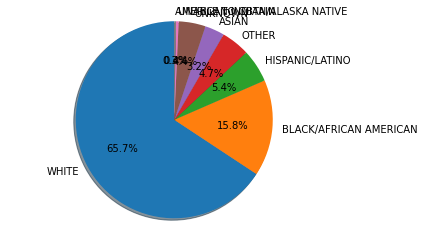

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(result_[''], labels=ethinicity_, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
gender_list = ['M', 'F']
age_range = [0, 20, 40, 60, 80]
ethinicity_ = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN', 'UNKNOWN', 'UNABLE TO OBTAIN', 'AMERICAN INDIAN/ALASKA NATIVE']
Labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

In [ ]:
def get_ethnicity(race):
  return {
      'WHITE':0,
      'BLACK/AFRICAN AMERICAN':1,
      'HISPANIC/LATINO':2,
      'OTHER':3,
      'ASIAN':4,
      'UNKNOWN':5,
      'UNABLE TO OBTAIN':6,
      'AMERICAN INDIAN/ALASKA NATIVE':7
  }.get(race, 5)

In [ ]:
# ethnicity_count = [0 for i in range(24)]

# for i in range(24):
#     ethnicity_count[i] = [0 for j in range(8)]

image_count = 0
asia_count = 0
latino_count = 0
white_count = 0
black_count = 0

list_0 = [0, 2, 3, 8, 20, 15]
list_1 = [6, 7, 12, 17, 18, 22]
list_2 = [16, 13, 14, 4, 9, 21]
list_3 = [23, 10, 5]
list_test = [1, 11, 19]

for i in list_test:
    filename = '/content/gdrive/MyDrive/TFrecords/mimic-tf-record{i}.tfrecords'.format(i=i)
    raw_dataset = tf.data.TFRecordDataset(filename)

    for raw_record in raw_dataset:
        
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
 
        ethnicity = example.features.feature['ethnicity'].int64_list.value[0]
        id = example.features.feature['subject_id'].int64_list.value[0]
        # gender = df_pa.loc[df_pa['subject_id'] == id, 'gender'].values
        # age = df_pa.loc[df_pa['subject_id'] == id, 'anchor_age'].values
        
        # ethnicity_count[i][ethnicity] += 1
        if (ethnicity == 2):
            latino_count += 1
        elif (ethnicity == 4):
            asia_count += 1
        elif (ethnicity == 0):
            white_count += 1
        elif (ethnicity == 1):
            black_count += 1
        else:
            continue
            
        image_count += 1

 
    # print('\n', filename, 'distribution')
    # for j in range(len(ethnicity_)):
    #   print(ethnicity_[j], ':', ethnicity_count_[j])
 
# print('\nOverall distribution')
# print('ethnicity in record:')
# for j in range(len(ethnicity_)):
#     print(ethnicity_[j], ':', ethnicity_count[j]/image_count)

# distribution = pd.DataFrame()
# for i in range(8):
#     distribution[Labels[i]] = count[i]

     
print('total images:', image_count)
print('white:', white_count/image_count)
print('black:', black_count/image_count)
print('latino:', latino_count/image_count)
print('asia:', asia_count/image_count)

total images: 26002
white: 0.7519421582955157
black: 0.1557572494423506
latino: 0.04953465118067841
asia: 0.042765941081455275


In [ ]:
total_ethinicity = [0 for i in range(8)]

for i in range(24):
    print('\nfile', i, ':')
    for j in range(8):
        print(ethinicity_[j], ':', ethinicity_count[i][j]/np.sum(ethinicity_count[i]))
        total_ethinicity[j] += ethinicity_count[i][j]

print('\ntotal distribution:')
for i in range(8):
    print(ethinicity_[i], ':', total_ethinicity[i]/np.sum(total_ethinicity))

In [ ]:
test = [0 for i in range(8)]
for i in [1, 11, 19]:
    for j in range(8):
        test[j] += ethinicity_count[i][j]

for i in range(8):
    print(ethinicity_[i], ':', test[i]) 

WHITE : 19552
BLACK/AFRICAN AMERICAN : 4050
HISPANIC/LATINO : 1288
OTHER : 1422
ASIAN : 1112
UNKNOWN : 866
UNABLE TO OBTAIN : 137
AMERICAN INDIAN/ALASKA NATIVE : 93


In [ ]:
distribution_H_age = pd.DataFrame()

distribution_H_age['Hispanic_0-20'] = W_age_count[0]
distribution_H_age['Hispanic_20-40'] = W_age_count[1]
distribution_H_age['Hispanic_40-60'] = W_age_count[2]
distribution_H_age['Hispanic_60-80'] = W_age_count[3]
distribution_H_age['Hispanic_80-'] = W_age_count[4]
distribution_H_age['diseases'] = Labels
distribution_H_age.set_index('diseases', inplace=True)

In [ ]:
distribution_H_gender = pd.DataFrame()

distribution_H_gender['Hispanic_Male'] = W_gender_count[0]
distribution_H_gender['Hispanic_FeMale'] = W_gender_count[1]

distribution_H_gender['diseases'] = Labels
distribution_H_gender.set_index('diseases', inplace=True)

In [ ]:
distribution_age_ratio = pd.concat([distribution_H_age, distribution_A_age], axis=1) 
distribution_gender_ratio = pd.concat([distribution_H_gender, distribution_A_gender], axis=1) 

In [ ]:
for i, r in distribution_age_ratio.iterrows():
    total = r.sum()
    distribution_age_ratio.loc[i] /= total

In [ ]:
path = '/content/gdrive/MyDrive/Racial_project_result/Hispanic_Asia_gender_ratio.csv'

distribution_gender_ratio.to_csv(path)

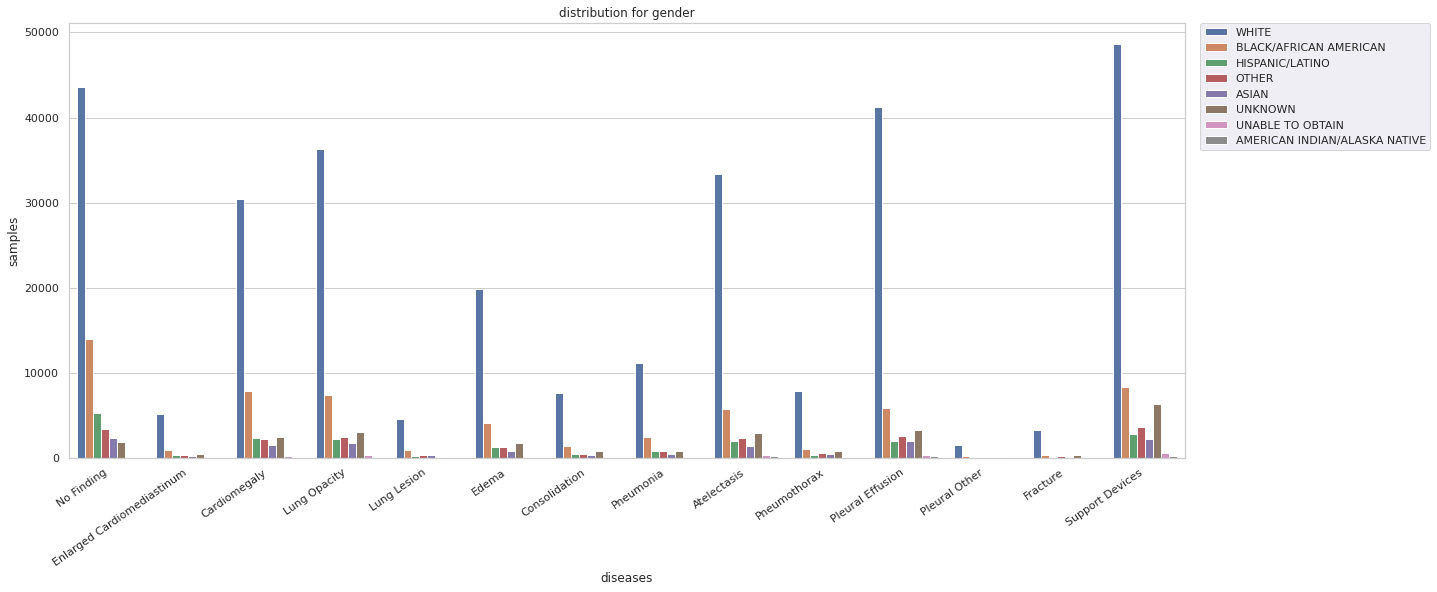

In [ ]:
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")


sns.set(style="whitegrid")
sns.barplot(x='diseases', y='samples', hue='ethinicity', data=result_, ax=ax).set_title('distribution for gender')
sns.set(font_scale=1)

h, l = ax.get_legend_handles_labels()
# counts = {'WHITE':1438, 'BLACK/AFRICAN AMERICAN':1438}
# l = [f'{yn} (n={c})' for yn,c in counts.items()]
ax.legend(h,l, loc='upper right', bbox_to_anchor=(1.22, 1), borderaxespad=0.)


In [ ]:
distribution.to_csv('/content/gdrive/MyDrive/Racial_project_result/ethnicity_symptoms_ratio.csv')

In [ ]:
for j in range(len(ethnicity_)):
  print(ethnicity_[j], ':', ethnicity_count[j])

WHITE : 70166
BLACK/AFRICAN AMERICAN : 14371
HISPANIC/LATINO : 3983
OTHER : 4326
ASIAN : 3376
UNKNOWN : 3870
UNABLE TO OBTAIN : 427
AMERICAN INDIAN/ALASKA NATIVE : 243


# Densenet121 use np.array

## model for classify 14 labels

In [ ]:
def define_model():
  INPUT_HWC = (256, 256, 1)
  base_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False, weights=None, input_shape=INPUT_HWC, pooling='max')

  x = tf.keras.layers.Dropout(0.5)(base_model.output)

  predictions = tf.keras.layers.Dense(14, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

  print(model.summary())

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
                )
  return model

In [ ]:
model = define_model()

list_0 = [0, 2, 3, 4, 5]
list_1 = [6, 7, 8, 9, 10]
list_2 = [16, 13, 14, 15, 23]
list_3 = [12, 17, 18, 20, 21, 22]

for num in range(15):
    for i in range(4):

        if (i == 0):
            files = list_0
        elif (i == 1):
            files = list_1
        elif (i == 2):
            files = list_2
        else :
            files = list_3

        X_train = []
        y_train = []

        for j in files:
            print('epoch:', num, 'now is loading file', j)
            filename = '/content/gdrive/My Drive/TFrecords/mimic-tf-record{i}.tfrecords'.format(i=i)
            raw_dataset = tf.data.TFRecordDataset(filename)
            
            for raw_record in raw_dataset:
                sub_y = []
            
                example = tf.train.Example()
                example.ParseFromString(raw_record.numpy())
                ethnicity = example.features.feature['ethnicity'].int64_list.value[0]
        
                sub_y.append(1 if example.features.feature['Atelectasis'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Cardiomegaly'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Consolidation'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Edema'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Enlarged Cardiomediastinum'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Fracture'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Lung Lesion'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Lung Opacity'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['No Finding'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pleural Effusion'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pleural Other'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pneumonia'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pneumothorax'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Support Devices'].float_list.value[0] == 1 else 0)
            
                nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
                img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)

                img_np = img_np/256
                img_np = np.float16(img_np)

                X_train.append(img_np)
                y_train.append(sub_y)

                del sub_y
                del img_np
        
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model.fit(X_train, y_train, batch_size=32, epochs=1, shuffle=True)

        del X_train
        del y_train

        gc.collect()

model.save('gdrive/MyDrive/saved_model/cxr_model')

## get_data_from_pretrained_model

In [3]:
base_model = models.load_model('/content/gdrive/MyDrive/saved_model/cxr_model_test_with_1_11_19')
new_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=base_model.get_layer('max_pool').output)
new_model.trainable = False
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [4]:
def get_data_from_pretrained_model():

    X_train_ = []
    X_test_ = []
    y_train = []
    y_test = []
    
    for i in range(24):
    
        print('now is loading file', i)
        filename = '/content/gdrive/My Drive/TFrecords/mimic-tf-record{i}.tfrecords'.format(i=i)
        raw_dataset = tf.data.TFRecordDataset(filename)
        
        X = []
        y = []
        for raw_record in raw_dataset:
            sub_y = []
        
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            ethnicity = example.features.feature['ethnicity'].int64_list.value[0]
    
            if (ethnicity == 0):
                sub_y = [1, 0, 0, 0]
    
            elif (ethnicity == 1):
                sub_y = [0, 1, 0, 0]
            
            elif (ethnicity == 2):
                sub_y = [0, 0, 1, 0]
            elif (ethnicity == 4):
                sub_y = [0, 0, 0, 1]
    
            else: 
                continue
    
            nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
            img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
    
            img_np = img_np/256
            img_np = np.float16(img_np)
    
            X.append(img_np)
    
            if (i == 1 or i == 11 or i == 19):
                y_test.append(sub_y)
            else:
                y_train.append(sub_y)
    
        
        if (i == 1 or i == 11 or i == 19):
            X_test_.append(new_model.predict(np.array(X)))
        else:
            X_train_.append(new_model.predict(np.array(X)))
            
        del X
        del y
        gc.collect()
    
    X_train = X_train_[0]
    for i in range(1, 21):
        X_train = np.append(X_train, X_train_[i], axis=0)
    
    del X_train_
    
    X_test = X_test_[0]
    for i in range(1, 3):
        X_test = np.append(X_test, X_test_[i], axis=0)
    
    del X_test_

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    gc.collect()
    
    return X_train, y_train, X_test, y_test

## transfer learning for classify race 1 layer percptron

In [ ]:
def get_model():
    input_layer = tf.keras.layers.Input(shape=(1024, ))
    x = tf.keras.layers.Dropout(0.5)(input_layer)
    x = tf.keras.layers.Dense(units=512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    out = tf.keras.layers.Dense(units=4, activation='softmax')(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=[out])

In [ ]:
model = get_model()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 2052      
Total params: 528,900
Trainable params: 527,876
Non-trainable params: 1,024
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics='acc'
                )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15)
model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_split=0.2, shuffle=True, callbacks=callback)

model.save('gdrive/MyDrive/saved_model/cxr_model_for_bias_testing_1layer_4ethnicity')

gc.collect()

Epoch 1/1000
4521/4521 [==============================] - 15s 3ms/step - loss: 0.2859 - acc: 0.8123 - val_loss: 0.8163 - val_acc: 0.2771
Epoch 2/1000
4521/4521 [==============================] - 14s 3ms/step - loss: 0.2455 - acc: 0.8410 - val_loss: 0.8200 - val_acc: 0.2762
Epoch 3/1000
4521/4521 [==============================] - 14s 3ms/step - loss: 0.2464 - acc: 0.8387 - val_loss: 0.8056 - val_acc: 0.2748
Epoch 4/1000
4521/4521 [==============================] - 14s 3ms/step - loss: 0.2448 - acc: 0.8388 - val_loss: 0.7577 - val_acc: 0.2874
Epoch 5/1000
4521/4521 [==============================] - 15s 3ms/step - loss: 0.2404 - acc: 0.8416 - val_loss: 0.8015 - val_acc: 0.2828
Epoch 6/1000
4521/4521 [==============================] - 14s 3ms/step - loss: 0.2406 - acc: 0.8406 - val_loss: 0.7690 - val_acc: 0.2807
Epoch 7/1000
4521/4521 [==============================] - 14s 3ms/step - loss: 0.2407 - acc: 0.8398 - val_loss: 0.7723 - val_acc: 0.2981
Epoch 8/1000
4521/4521 [=================

1324293

## Use traditional clf to test bias

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

X_train, y_train, X_test, y_test = get_data_from_pretrained_model()
 
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=15)).fit(X_train, y_train)
 
svm = OneVsRestClassifier(LinearSVC(random_state=0, tol=1e-5, kernel='linear')).fit(X_train, y_train)
 
lr = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X_train, y_train)

now is loading file 0
now is loading file 1
now is loading file 2
now is loading file 3
now is loading file 4
now is loading file 5
now is loading file 6
now is loading file 7
now is loading file 8
now is loading file 9
now is loading file 10
now is loading file 11
now is loading file 12
now is loading file 13
now is loading file 14
now is loading file 15
now is loading file 16
now is loading file 17
now is loading file 18
now is loading file 19
now is loading file 20
now is loading file 21
now is loading file 22
now is loading file 23


# Testing

## testing 14 labels classifier -每個label的準確度拆開來算 auc

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/saved_model/cxr_model_for_bias_testing_1layer_4ethnicity')

In [ ]:
ethnicity_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'ASIAN']
Labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']
gender_list = ['M', 'F']
age_range = [0, 20, 40, 60, 80]

In [ ]:
def get_ethnicity(race):
  return {
      'WHITE':0,
      'BLACK/AFRICAN AMERICAN':1,
      'HISPANIC/LATINO':2,
      'OTHER':4,
      'ASIAN':3,
      'UNKNOWN':5,
      'UNABLE TO OBTAIN':6,
      'AMERICAN INDIAN/ALASKA NATIVE':7
  }.get(race, 5)

In [ ]:
def get_test_data(target): 
    X_test = []
    y_test = []
    tf_list = [1, 11, 19]
  
    for i in tf_list:
        filename = '/content/gdrive/MyDrive/TFrecords/mimic-tf-record{i}.tfrecords'.format(i=i)
        raw_dataset = tf.data.TFRecordDataset(filename)
        for raw_record in raw_dataset:
            sub_y = []
            weight = []

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy()) 

            ethnicity = example.features.feature['ethnicity'].int64_list.value[0]

            if (example.features.feature['ethnicity'].int64_list.value[0] == get_ethnicity(target)):
                sub_y.append(1 if example.features.feature['Atelectasis'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Cardiomegaly'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Consolidation'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Edema'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Enlarged Cardiomediastinum'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Fracture'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Lung Lesion'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Lung Opacity'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['No Finding'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pleural Effusion'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pleural Other'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pneumonia'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Pneumothorax'].float_list.value[0] == 1 else 0)
                sub_y.append(1 if example.features.feature['Support Devices'].float_list.value[0] == 1 else 0)

                nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
                img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)

                img_np = img_np/256
                img_np = np.float16(img_np)

                y_test.append(sub_y)
                X_test.append(img_np)

                del sub_y
                del img_np

    return np.array(X_test), np.array(y_test)

In [ ]:
def test_and_plot(model, X_test, y_test, name=''):
  scores = [ 0 for i in range(15)] 

  # fig, axs = plt.subplots(3,5, figsize=(16, 8), sharex=True, sharey=True, facecolor='w', edgecolor='k')
  # fig.subplots_adjust(hspace=.5, wspace=.1)

  # fig.suptitle('ROC curve for {i}'.format(i=name), fontsize=16)
  # plt.title('Receiver Operating Characteristic')

  # axs = axs.ravel()

  # total_score = 0
  preds = model.predict(X_test)

  for j in range(0, 14):
    fpr, tpr, threshold = roc_curve(y_test[:, j], preds[:, j], pos_label=1)
    roc_auc = auc(fpr, tpr)
    scores[j] = roc_auc

    # axs[i-1].set_title(name)
    # axs[i-1].plot(fpr, tpr, 'b', label='AUC score = %0.2f' % roc_auc)
    # axs[i-1].plot([0, 1], [0, 1],'r--')
    # axs[i].ylabel('True Positive Rate')
    # axs[i].xlabel('False Positive Rate')

    # axs[i-1].legend(loc='lower center')

  # plt.show()

  return scores

## draw barplot

In [ ]:
result = pd.DataFrame()

for i in ethnicity_list:
  print('testing', i)
  X_test, y_test = get_test_data(i)
  print(i, 'has', len(X_test), 'images')
  one_result = test_and_plot(model, X_test, y_test, i)
  one_result = np.array(one_result)
  print('auc scores for', i, 'are', one_result)
  result[i] = one_result

testing WHITE
WHITE has 19552 images
auc scores for WHITE are [0.77019596 0.80326679 0.79589515 0.85999205 0.7010902  0.69060115
 0.72781636 0.70789618 0.83506915 0.8886128  0.75437972 0.67686834
 0.80097601 0.84114316 0.        ]
testing BLACK/AFRICAN AMERICAN
BLACK/AFRICAN AMERICAN has 4050 images
auc scores for BLACK/AFRICAN AMERICAN are [0.78994031 0.81306791 0.83707903 0.87991774 0.76021886 0.63225839
 0.71526435 0.74565699 0.8461325  0.90789837 0.77500827 0.69945875
 0.83196911 0.88700952 0.        ]
testing HISPANIC/LATINO
HISPANIC/LATINO has 1288 images
auc scores for HISPANIC/LATINO are [0.80149785 0.8206277  0.77788978 0.88248726 0.76575979 0.60654622
 0.69056539 0.75655676 0.88402569 0.90781573 0.87139517 0.65651077
 0.81609256 0.8780617  0.        ]
testing ASIAN
ASIAN has 1422 images
auc scores for ASIAN are [0.72925169 0.77192155 0.78094148 0.82332688 0.63854576 0.64546011
 0.76070716 0.69712507 0.82209335 0.84600002 0.82322875 0.70225815
 0.74933155 0.81128147 0.        

In [ ]:
result = result.drop(14, axis=0)
result['diseases'] = Labels
result

,WHITE,BLACK/AFRICAN AMERICAN,HISPANIC/LATINO,ASIAN,diseases
0,0.770196,0.789940,0.801498,0.729252,Atelectasis
1,0.803267,0.813068,0.820628,0.771922,Cardiomegaly
2,0.795895,0.837079,0.777890,0.780941,Consolidation
3,0.859992,0.879918,0.882487,0.823327,Edema
4,0.701090,0.760219,0.765760,0.638546,Enlarged Cardiomediastinum
5,0.690601,0.632258,0.606546,0.645460,Fracture
6,0.727816,0.715264,0.690565,0.760707,Lung Lesion
7,0.707896,0.745657,0.756557,0.697125,Lung Opacity
8,0.835069,0.846132,0.884026,0.822093,No Finding
9,0.888613,0.907898,0.907816,0.846000,Pleural Effusion


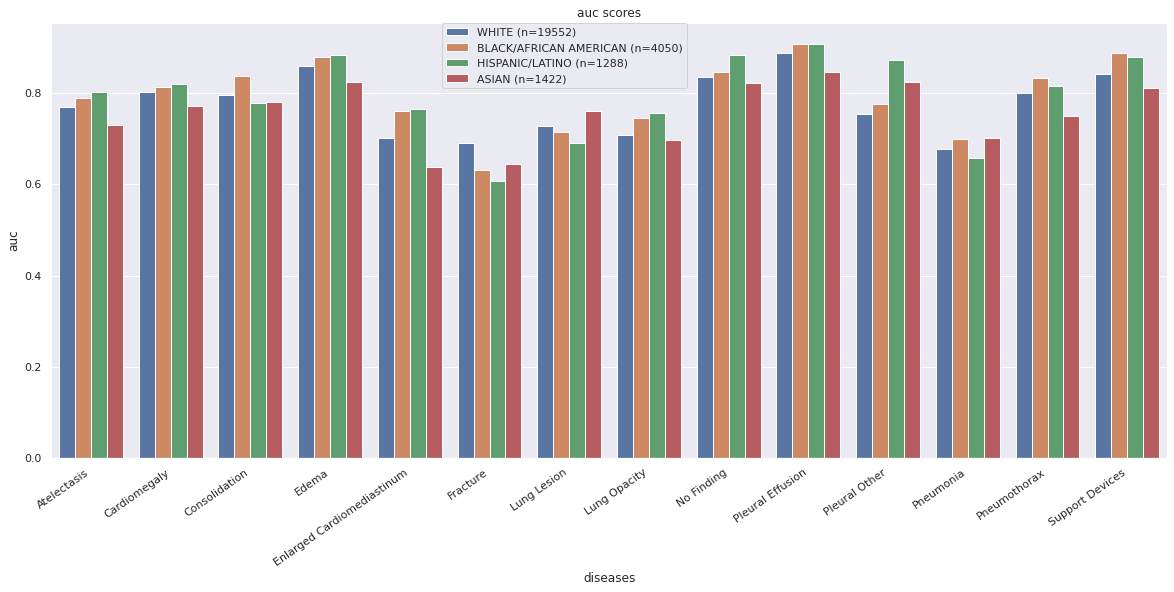

In [ ]:
result_ = pd.melt(result, id_vars='diseases', var_name='ethnicity', value_name='auc')

fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")


sns.set(style="whitegrid")
sns.barplot(x='diseases', y='auc', hue='ethnicity', data=result_, ax=ax).set_title('auc scores')
sns.set(font_scale=1)

h, l = ax.get_legend_handles_labels()
counts = {'WHITE':19552, 'BLACK/AFRICAN AMERICAN':4050, 'HISPANIC/LATINO':1288, 'ASIAN':1422}
l = [f'{yn} (n={c})' for yn,c in counts.items()]
ax.legend(h,l, bbox_to_anchor=(0.35, 1), loc=2, borderaxespad=0.)


## plot roc curve and confusion matrix

In [ ]:
import numpy as np
 
 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
 
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
 
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
 
    title:        the text to display at the top of the matrix
 
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
 
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
 
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
 
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
    file_name = '/content/gdrive/MyDrive/Racial_project_result/' + title + '.png'
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)
    plt.show()

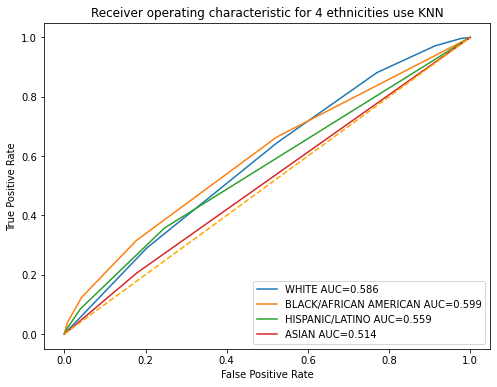

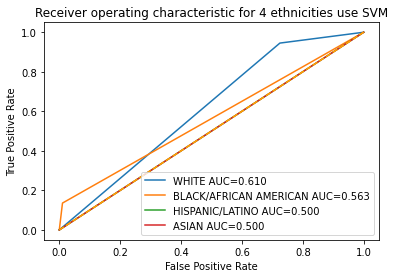

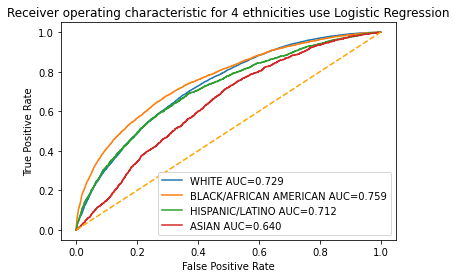

In [ ]:
from sklearn.metrics import classification_report
fig = plt.figure(figsize=(8,6))
 
# preds = model.predict(X_test)
preds_knn = knn.predict_proba(X_test)
preds_svm = svm.predict(X_test)
preds_lr = lr.predict_proba(X_test)
 
list_ = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'ASIAN']
 
for i in range(4):
    fpr_knn, tpr_knn, _knn = roc_curve(y_test[:, i], preds_knn[:, i])
    roc_auc = auc(fpr_knn, tpr_knn)
    # plot the roc curve for the model
    plt.plot(fpr_knn, tpr_knn, linestyle='solid', label='{} AUC={:.3f}'.format(list_[i], roc_auc))
 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 4 ethnicities use KNN')
plt.legend(loc="lower right")
 
plt.plot([0,1], [0,1], color='orange', linestyle='--')
file_name = '/content/gdrive/MyDrive/Racial_project_result/roc_for_4_ethnicities_use_KNN.png'
plt.savefig(file_name)
plt.show()
 
 
for i in range(4):
    fpr_svm, tpr_svm, _svm = roc_curve(y_test[:, i], preds_svm[:, i])
    roc_auc = auc(fpr_svm, tpr_svm)
    # plot the roc curve for the model
    plt.plot(fpr_svm, tpr_svm, linestyle='solid', label='{} AUC={:.3f}'.format(list_[i], roc_auc))
 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 4 ethnicities use SVM')
plt.legend(loc="lower right")
 
plt.plot([0,1], [0,1], color='orange', linestyle='--')
file_name = '/content/gdrive/MyDrive/Racial_project_result/roc_for_4_ethnicities_use_SVM.png'
plt.savefig(file_name)
plt.show()
 
for i in range(4):
    fpr_lr, tpr_lr, _lr = roc_curve(y_test[:, i], preds_lr[:, i])
    roc_auc = auc(fpr_lr, tpr_lr)
    # plot the roc curve for the model
    plt.plot(fpr_lr, tpr_lr, linestyle='solid', label='{} AUC={:.3f}'.format(list_[i], roc_auc))
 
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 4 ethnicities use Logistic Regression')
plt.legend(loc="lower right")
# show the plot
 
plt.plot([0,1], [0,1], color='orange', linestyle='--')
file_name = '/content/gdrive/MyDrive/Racial_project_result/roc_for_4_ethnicities_use_LR.png'
plt.savefig(file_name)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
 
# preds_ = np.round(preds)
knn_preds_ = knn.predict(X_test)
svm_preds_ = svm.predict(X_test)
lr_preds_ = lr.predict(X_test)
 
 
target_name = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'ASIAN']
# cf_matrix_knn = confusion_matrix(y_test, np.round(preds_knn))
# cf_matrix_svm = confusion_matrix(y_test, np.round(preds_svm))
# cf_matrix_lr = confusion_matrix(y_test, np.round(preds_lr))
 
cm_knn = [0 for i in range(4)]
cm_svm = [0 for i in range(4)]
cm_lr = [0 for i in range(4)]
for i in range(4):
    cm_knn[i] = [0 for j in range(4)]
    cm_svm[i] = [0 for j in range(4)]
    cm_lr[i] = [0 for j in range(4)]
 
for i in range(len(y_test)):
    cm_knn[np.argmax(knn_preds_[i])][np.argmax(y_test[i])] += 1
    cm_svm[np.argmax(svm_preds_[i])][np.argmax(y_test[i])] += 1
    cm_lr[np.argmax(lr_preds_[i])][np.argmax(y_test[i])] += 1
 
plot_confusion_matrix(np.array(cm_knn).transpose(), 
                      normalize = False,
                      target_names = target_name,
                      title = "Confusion Matrix for 4 ethnicities use KNN")
 
plot_confusion_matrix(np.array(cm_svm).transpose(), 
                      normalize = False,
                      target_names = target_name,
                      title = "Confusion Matrix for 4 ethnicities use SVM")
 
plot_confusion_matrix(np.array(cm_lr).transpose(), 
                      normalize = False,
                      target_names = target_name,
                      title = "Confusion Matrix for 4 ethnicities use Logistic Regression")
 
print('KNN acc:', accuracy_score(y_test, knn_preds_))
print('SVM acc:', accuracy_score(y_test, svm_preds_))
print('Logistic Regression acc:', accuracy_score(y_test, lr_preds_))

# racial classifier heatmap

In [ ]:
X_test, y_test = get_test_data('')
preds = model.predict(X_test)

In [ ]:
model.outputs[0][5]

<tf.Tensor 'strided_slice_24:0' shape=(5,) dtype=float32>

In [ ]:
from tensorflow.keras import backend as K
from keras.applications import imagenet_utils


def gradcam(model, preds):
    # 取得影像的分類類別
    # preds = model.predict(x)
    pred_class = np.argmax(preds[0])
    
    # 取得影像分類名稱
    # pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]
    
    # 預測分類的輸出向量
    pred_output = model.outputs[0][1]
    print(pred_output)
    
    # 最後一層 convolution layer 輸出的 feature map
    # ResNet 的最後一層 convolution layer
    last_conv_layer = model.get_layer('conv5_block16_2_conv')
    
    # 求得分類的神經元對於最後一層 convolution layer 的梯度
    with tf.GradientTape() as tape:
      grads = tape.gradient(pred_output, last_conv_layer.output)
    
    print(grads)
    
    # 求得針對每個 feature map 的梯度加總
    pooled_grads = K.sum(grads, axis=(0, 1, 2))
    
    # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
    # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
    # 的方式。
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
        
    # 計算 feature map 的 channel-wise 加總
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    
    return heatmap

In [ ]:
def plot_heatmap(heatmap, img, pred_class_name):
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # 正規化
    heatmap /= np.max(heatmap)
    
    # 讀取影像
    img = cv2.fromarray(img)
    
    fig, ax = plt.subplots()
    
    im = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))

    # 拉伸 heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    
    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)
    
    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    
    plt.title(pred_class_name)
    
    plt.show()

In [ ]:
heatmap, pred_class_name = gradcam(model, preds)

plot_heatmap(heatmap, X_test[0])

Tensor("strided_slice_8:0", shape=(5,), dtype=float32)
None


ValueError: ignored